# Stochastic sampling for computational inference

### Colm Talbot - 200626

In [1]:
%pylab inline

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Computer Modern Roman"
mpl.rcParams["font.size"] = 20
mpl.rcParams["text.usetex"] = True
mpl.rcParams["grid.alpha"] = 0
mpl.rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'

from scipy.special import beta


def prior(fraction_in_first_half):
    return 1 * (fraction_in_first_half >= 0) * (fraction_in_first_half <= 1)


def ln_likelihood(number_in_first_half, number_in_second_half, point):
    return (
        number_in_first_half * np.log(point)
        + number_in_second_half * np.log(1 - point)
    )


def likelihood(number_in_first_half, number_in_second_half, fraction_in_first_half):
    return np.exp(ln_likelihood(number_in_first_half, number_in_second_half, fraction_in_first_half))


def evidence(number_in_first_half, number_in_second_half):
    return beta(number_in_first_half + 1, number_in_second_half + 1)


def posterior(
    number_in_first_half, number_in_second_half, fraction_in_first_half
):
    return (
        likelihood(number_in_first_half, number_in_second_half, fraction_in_first_half)
        * prior(fraction_in_first_half)
        / evidence(number_in_first_half, number_in_second_half)
    )

Populating the interactive namespace from numpy and matplotlib


# Background

Astrophysical inference problems often depend on many ($O(10)$ - $O(100)$) parameters.

Grid based methods fail in spaces with more than a handful of parameters.

We need a different method to determine the posterior/evidence.

This is typically performed using stochastic sampling.

# Importance sampling and Monte Carlo integration

We can estimate the posterior by performing [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling) and evidences using [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration).

## Importance sampling

Draw from the prior distribution

$$\{\theta_i\} \sim \pi(\theta | M, I)$$

Weight the samples by the likelihood to convert these prior samples to samples from the posterior.

$$ w_i = \mathcal{L}(d | \theta_i, M, I) $$

Weighted samples are drawn from the posterior.

$$\{\theta_i\}_{w} \sim p(\theta | d, M, I)$$

These can either be used as weights, or we can [rejection sample](https://en.wikipedia.org/wiki/Rejection_sampling) by keeping points in proportion to their weight.

## Importance sampling - Monte Carlo integration

The mean weight is the evidence

$$ \mathcal{Z}(d| M, I) \approx \left< w_i \right> = \frac{1}{N} \sum^{N}_{i=1} w_i $$

This method of averaging weights is known as Monte Carlo integration.

The uncertainty in the estimate is given by

$$ \sigma_{\mathcal{Z}} = \frac{V}{N^{1/2}} \sigma_w $$

where $V$ is the prior volume and $N$ is the number of samples.

## Importance sampling - efficiency

The efficiency of importance sampling is quantified using the Kish effective sample size

$$ n_{\text{eff}} = \frac{(\sum^{N}_{i=1} w_i)^2}{\sum^{N}_{i=1} w^2_i} \qquad;\qquad \text{efficiency} = \frac{n_\text{eff}}{N} $$

In [2]:
number_in_first_half = 10
number_in_second_half = 9
prior_samples = np.random.uniform(0, 1, 100000)

weights = likelihood(number_in_first_half, number_in_second_half, prior_samples)

keep = weights >= np.random.uniform(0, max(weights), len(weights))
rejection_sampled_posterior_samples = prior_samples[keep]

hist_kwargs = dict(bins=np.linspace(0, 1, 100), histtype="step", density=True)

f_values = np.linspace(0, 1, 1000)
posterior_values = posterior(number_in_first_half, number_in_second_half, f_values)

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


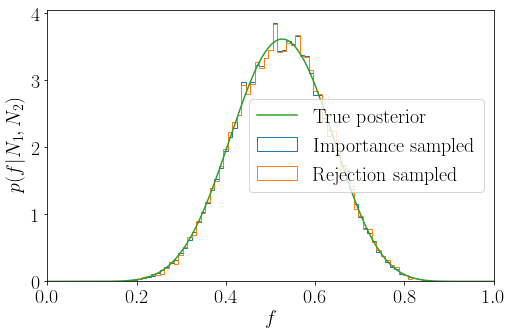

Monte Carlo evidence = 5.449425775121937e-07 +/- 2.173041050008235e-09
True evidence = 5.412544112234514e-07
Sampling efficiency = 0.38608005429766895


In [3]:
plt.figure(figsize=(8, 5))
plt.hist(prior_samples, weights=weights, label="Importance sampled", **hist_kwargs)
plt.hist(rejection_sampled_posterior_samples, label="Rejection sampled", **hist_kwargs)
plt.plot(f_values, posterior_values, label="True posterior")
plt.xlim(0, 1)
plt.xlabel("$f$")
plt.ylabel("$p(f|N_1, N_2)$")
plt.legend()
plt.show()
plt.close()

print(f"Monte Carlo evidence = {np.mean(weights)} +/- {np.std(weights) / len(weights) ** 0.5}")
print(f"True evidence = {evidence(number_in_first_half, number_in_second_half)}")
print(f"Sampling efficiency = {np.sum(weights) ** 2 / np.sum(weights ** 2) / len(weights)}")

## Importance sampling - limitations

This is a neat little method which can be run quickly and easily.

However, while the efficiency scales better with the dimensionality than grid-based methods, it still scales poorly with increasing dimensionality.

Specifically, the efficiency is proportional to the ratio of the posterior volume to the prior volume.

It therefore performs worse when the data is more informative and the likelihood is more peaked.

# Markov Chain Monte Carlo (MCMC)

[MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) is a widely used family of algortihms for generating samples from a target distribution using a biased random walk.

## Metropolis-Hastings

The [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) is a relatively simple MCMC algorithm which is ideal for beginners.

First we should define some terms:
- $f(\theta)$: the target distribution, this is the distribution we're aiming to generate samples from, typically the posterior
- $g(\theta' | \theta)$: the proposal distribution, this is the probability of moving from $\theta$ to $\theta'$
  - a simple, widely used, proposal is a normal distribution
- $A(\theta, \theta')$: the acceptance function for a step from $\theta$ to $\theta'$
  - for our case this will be $A(\theta, \theta') = \min\left(1, \frac{f(\theta')}{f(\theta)}\right)$
  - i.e., if $f(\theta') >= f(\theta)$ the step is always accepted
  - otherwise the point is accepted based on the ratio

## Metropolis-Hastings - algorithm

The algorithm proceeds as follows:

- Choose a starting point $\theta$
- Until finished:
  - Propose a new point $\theta'$ according to $g$
  - Evaluate the acceptance ratio and draw a random number $u$ between [0, 1].
    - If $A(\theta, \theta') \geq 0$, set $\theta = \theta'$
    - Else, $\theta$ remains the same
  - Append $\theta$ to the chain

## Metropolis-Hastings - caveats

While the chain generated by Metropolis-Hastings algorithm has samples faithfully drawn from the target distribution once the chain reaches a steady state there are a number of caveats:
- the chain must reach the steady state before points start being added to the posterior
  - this is known as burn-in, determining wheteher a chain has burnt-in is non-trivial
- after burn-in has been acheived, the samples are not independent samples from the posterior as neighbouring samples in the chain are correlated
  - the chain should therefore be "thinned" according to the auto-correlation length to obtain independent samples
- there isn't a well-defined termination for the algorithm, there are a number of methods use to determine when to stop:

| Condition | Advantages | Disadvantages |
| --------- | ---------- | ------------- |
| Fixed time | Known run time | Unknown number of output samples |
| Fixed number of iterations | Known run time | Unknown number of output samples |
| Fixed number of samples | Known number of output samples | Unknown run time |

## Metropolis-Hastings - choosing the starting point

A good choice of starting point can really help reduce the burn in.

Generally, the closer you start to the peak, the less time it takes to burn in.

A few ways to choose starting points:
- choose randomly from the prior
  - requires very little effort, may take a long time to burn in
- choose based on an informed guess
  - if you have an initial estimate that you think is close to the peak likelihood, use that
- choose based on an automated guess
  - run an optimisation algorithm on the likelihood to find the peak and start from there

In [4]:
chain = list()
current_point = 0.5
current_ln_likelihood = ln_likelihood(
    number_in_first_half, number_in_second_half, current_point
)
step_size = 0.01

from tqdm import trange
for _ in trange(1000000):
    new_point = current_point + np.random.normal(0, step_size)
    new_prior = prior(new_point)
    if new_prior == 0:
        chain.append(current_point)
        continue
    new_ln_likelihood = ln_likelihood(
        number_in_first_half, number_in_second_half, new_point
    )
    acceptance = min(0, new_ln_likelihood - current_ln_likelihood)
    if acceptance >= np.log(np.random.uniform(0, 1)):
        current_point = new_point
    chain.append(current_point)

100%|██████████| 1000000/1000000 [00:10<00:00, 96637.92it/s]


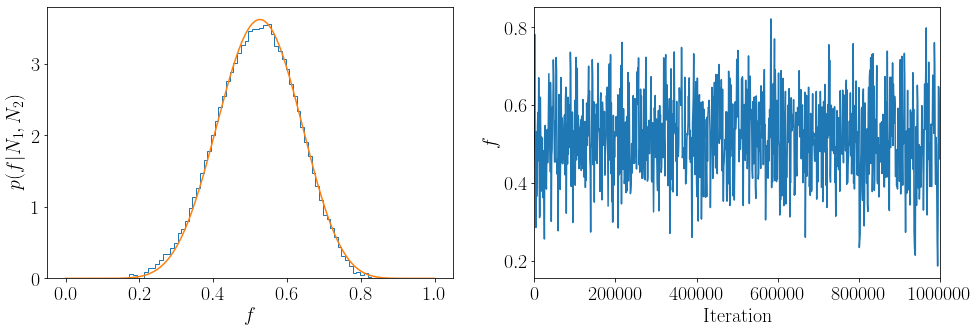

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax = axes[0]
ax.hist(chain, **hist_kwargs, label="MCMC samples")
ax.plot(f_values, posterior_values, label="True posterior")
ax.set_xlabel("$f$")
ax.set_ylabel("$p(f | N_1, N_2)$")

ax = axes[1]
ax.plot(np.arange(0, len(chain), 1000), chain[::1000])
ax.set_xlabel("Iteration")
ax.set_ylabel("$f$")
ax.set_xlim(0, len(chain))
plt.show()
plt.close()

## MCMC - summary

This is by no means a thorough introduction to MCMC.

_TODO_: Add some helpful links

# Nested Sampling

[Nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) is an alternate algorithm which is designed to compute the evidence rather than sample the posterior distribution.

However, posterior samples can be trivially extracted from the output of nested sampling.

## Nested sampling - basics

Nested sampling reduces the N-dimensional integral for the evidence to a 1-dimensional integral.

This is done by proposing a mapping $X(\mathcal{L})$ which is the fraction of the prior space with likeihood greater than $\mathcal{L}(d | \theta, M, I)$.

$$ X(\mathcal{L}) = \int_{\mathcal{L(d | \theta, M, I)} > \mathcal{L}} d\theta' \pi(\theta' | M, I) $$

We can then see that the differential element

$$ dX(\mathcal{L}) = X(\mathcal(L) + \delta\mathcal{L}) - X(\mathcal(L) + \delta\mathcal{L}) $$
$$ dX(\mathcal{L}) = \int_{\mathcal{L} < \mathcal{L(d | \theta, M, I)} < \mathcal{L} + \delta \mathcal{L}} d\theta' \pi(\theta' | M, I) $$

is the fraction of the prior mass between $\mathcal{L}$ and $\mathcal{L} + \delta \mathcal{L}$.

## Nested sampling - basics

We can therefore write the evidence integral as a 1-dimensional integral over $X$

$$ \mathcal{Z}(d | M, I) = \int^{1}_{0} dX \, X(\mathcal{L}(d | \theta, M, I))$$

## Nested sampling - algorithm

- Draw N points from the prior as the "live" points
- Initialise $Z = 0$, $X_0 = 1$
- For iteratinon, $i$, until finished:
  - Identify the point $\theta_i$ with the lowest likelihood $\mathcal{L}_i = \mathcal{L}_{\min}$
  - Estimate the $X_i(\mathcal{L}_{\min})$
  - Compute the prior weight $w_i = X_{i - 1} - X_{i}$
  - Increment $Z = Z + \mathcal{L}_{\min} w_i$
  - Append $\theta_i$ to list of "dead" points
  - Replace $\theta_i$ with a higher likelihood point
- $Z = Z + \sum\left(\frac{\text{live} \mathcal{L} X_i}{N}\right)$
- Add live points to the dead points
- Importance sample dead points according to $\mathcal{L}_{i} w_i$

## Nested sampling - estimating $X$

We have $N$ live points drawn uniformly from the prior with likelihood above some threshold.

By definition the $X$ values corresponding to these points are uniformly distributed in $X \in [0, X_{i - 1}]$.

The largest $X$ value correpsonds to the lowest likelihood point.

The fraction of this space with $X$ larger than $X(\mathcal{L}_{\min})$ is determined by the [maximum order statistic](https://en.wikipedia.org/wiki/Order_statistic)

$$ p(X(\mathcal{L}_{\min})) = N \left(\frac{X}{X_{i - 1}}\right)^{N - 1} \equiv N t_i^{N-1} $$

We are actually interested in $\ln t$ and in practice, we use the expectation of this

$$ \ln\left(\frac{X_i}{X_{i - 1}}\right) \approx \left< \ln t_i \right> = - \frac{1}{N} $$

## Nested sampling - generating new points

Drawing new points from the constrained prior space is the main challenge of nested sampling.

There are multiple methods which have been used.

- draw randomly from the full prior
  - this is basically the same as the importance sampling above
  - as a result this gets massively inefficient
- construct ellipsoids around the current live points and draw samples from these ellipses
  - this is very good for neat, approximately Gaussian, likelihoods
  - gravitational-wave transient likelihoods are not nice
  - also doesn't scale well to large dimensional spaces
- generate samples with an MCMC walk
  - this method works as well as your MCMC
  - this is the method we generally use

## Nested sampling - termination

Since the algorithm is just ordering the likelihood and estimating the associated prior volume, it can continue indefinitely.

However, there are multiple used stopping conditions

| Condition | Advantages | Disadvantages |
| --------- | ---------- | ------------- |
| Remaining evidence | Understandable convergence of the result | Unknown number of samples/sampling time |
| Fixed time | Known run time | Unknown number of output samples/convergence |
| Fixed number of iterations | Known run time | Unknown number of output samples/output samples |
| Fixed number of samples | Known number of output samples | Unknown run time/convergence |

## Nested sampling - termination

### Remaining evidence

This is the most widely used termination condition.

An upper bound on the remaining evidence to be accumulated can be approximated assuming the remaining prior volume all has likelihood equal to the maximum identified likelihood.
$$\delta \mathcal{Z} = X_i \mathcal{L_\max}$$

We then terminate the algorithm when $ \ln \delta \mathcal{Z} - \ln \mathcal{Z_i} < \epsilon$.

The typical value of $\epsilon$ used in gravitational-wave analyses is $0.1$, but this is not a magic number!

# Exercises

- Implement a more sophisticated proposal distribution for MCMC, some options include
  - Ensemble affine-invariant proposal
  - Hamiltonian Monte Carlo
- Implement an autocorrelation length calculation for the MCMC sampler to thin the chain
- Implement an optimiser to automate finding the starting point, see https://docs.scipy.org/doc/scipy/reference/optimize.html
- Implement a nested sampler